https://www.investopedia.com/terms/r/renkochart.asp

## Renko graphs

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


class Renko():
    def __init__(self, name=None):
        self.name = name


class RenkoFixBrickSize(Renko):
    def __init__(self, brick_size, name=None):
        Renko.__init__(self, name)
        self.brick_size = float(brick_size)
        self.renko = pd.DataFrame(
            columns=['price_last', 'price_renko', 'price_min', 'price_max',
                     'dt_start', 'dt_end', 'trend',
                     'volume', 'count', 'cons_up', 'cons_down',
                     ],
            dtype='int64',
        )
        self.renko[['trend', 'count', 'cons_up', 'cons_down']] = self.renko[
            ['trend', 'count', 'cons_up', 'cons_down']].astype(int)
        self.renko[['price_last', 'price_renko', 'price_min', 'price_max', 'volume']] = self.renko[
            ['price_last', 'price_renko', 'price_min', 'price_max', 'volume']].astype(float)
        self.renko[['dt_start', 'dt_end']] = self.renko[
            ['dt_start', 'dt_end']].astype('datetime64[ns]').tz_localize('UTC')

    def _initial_brick(self, price, date, volume):
        (brick_lower_limit, brick_upper_limit) = (price - self.brick_size, price + self.brick_size)

        new_brick = {
            'price_last': price,
            'price_renko': price,
            'price_min': brick_lower_limit,
            'price_max': brick_upper_limit,
            'trend': 0,
            'count': 1,
            'cons_up': 0,
            'cons_down': 0,
        }

        # Add optional info
        if date is not None:
            new_brick['dt_start'] = date
            new_brick['dt_end'] = date
        if volume is not None:
            new_brick['volume'] = volume

        self.renko = self.renko.append(new_brick, ignore_index=True)

    def _new_brick(self, price, date, volume):
        while True:
            last_brick = self.renko.iloc[-1]

            if price >= last_brick.price_max:
                cons_down = 0
                if last_brick.trend < 0:
                    multiplier = 2
                    cons_up = 1
                else:
                    multiplier = 1
                    cons_up = last_brick.cons_up + 1

                new_price_renko = last_brick.price_renko + multiplier * self.brick_size
                brick_upper_limit = new_price_renko + self.brick_size
                brick_lower_limit = new_price_renko - 2 * self.brick_size
                new_trend = 1

            elif price <= last_brick.price_min:

                cons_up = 0
                if last_brick.trend > 0:
                    multiplier = 2
                    cons_down = 1
                else:
                    multiplier = 1
                    cons_down = last_brick.cons_down + 1

                new_price_renko = last_brick.price_renko - multiplier * self.brick_size
                brick_upper_limit = new_price_renko + 2 * self.brick_size
                brick_lower_limit = new_price_renko - self.brick_size
                new_trend = -1
            else:
                self.renko.loc[self.renko.index[-1], 'count'] = 1
                if volume is not None:
                    self.renko.loc[self.renko.index[-1], 'volume'] = volume
                break

            new_brick = {
                'price_last': price,
                'price_renko': new_price_renko,
                'price_min': brick_lower_limit,
                'price_max': brick_upper_limit,
                'trend': new_trend,
                'count': 0,
                'volume': 0,
                'cons_up': cons_up,
                'cons_down': cons_down,
            }

            # Add optional info
            if date is not None:
                new_brick['dt_start'] = date
                new_brick['dt_end'] = date

            self.renko = self.renko.append(new_brick, ignore_index=True)

    def new_quotes(self, prices, dates=None, volumes=None):
        if dates is None:
            dates = [None] * len(prices)
        if volumes is None:
            volumes = [None] * len(prices)

        if len(self.renko) == 0:
            self._initial_brick(prices[0], dates[0], volumes[0])
            return self.new_quotes(prices[1:], dates[1:], volumes[1:])

        for (price, date, volume) in zip(prices, dates, volumes):
            last_brick = self.renko.iloc[-1]

            if price >= last_brick.price_max:
                if date is not None:
                    self.renko.loc[self.renko.index[-1], 'dt_end'] = date
                self._new_brick(price, date, volume)
            elif price <= last_brick.price_min:
                if date is not None:
                    self.renko.loc[self.renko.index[-1], 'dt_end'] = date
                self._new_brick(price, date, volume)
            else:
                # The quote is in the same renko brick
                self.renko.loc[self.renko.index[-1], 'price_last'] = price
                self.renko.loc[self.renko.index[-1], 'count'] += 1
                if date is not None:
                    self.renko.loc[self.renko.index[-1], 'dt_end'] = date
                if volume is not None:
                    self.renko.loc[self.renko.index[-1], 'volume'] += volume

        pass

    def performance(self):
        count = self.renko['count'].sum()
        renko_bricks = self.renko.shape[0]
        try:
            price_to_brick_ratio = count / renko_bricks
        except ZeroDivisionError:
            price_to_brick_ratio = 0

        sign_changes = (self.renko.trend != self.renko.trend.shift()).sum() - 2
        if sign_changes < 0:
            sign_changes = 0

        balance = (
            self.renko.trend[2:].reset_index(drop=True) ==
            self.renko.trend[1:-1].reset_index(drop=True)
        ).replace({True: 1, False: -2}).sum()

        if sign_changes == 0:
            score = balance
        else:
            score = balance / sign_changes

        if score >= 0 and price_to_brick_ratio >= 1:
            score = np.log(score + 1) * np.log(price_to_brick_ratio)
        else:
            score = -1.0

        ret = {
            'count': count,
            'renko_bricks': renko_bricks,
            'price_to_brick_ratio': price_to_brick_ratio,
            'sign_changes': sign_changes,
            'balance': balance,
            'score': score,
        }

        return ret

    def graph(self, title=None, col_up='green', col_down='red'):

        if title is None:
            title = 'Renko chart - bs: %f' % self.brick_size

        fig, ax = plt.subplots(1, figsize=(20, 10))
        ax.set_title(title)
        ax.set_xlabel('Renko bars')
        ax.set_ylabel('Price')

        # Calculate the limits of axes
        ax.set_xlim(0.0,
                    len(self.renko['price_renko']) + 1.0)

        if self.renko.shape[0] > 0:
            ax.set_ylim(np.min(self.renko['price_renko']) - 3.0 * self.brick_size,
                        np.max(self.renko['price_renko']) + 3.0 * self.brick_size)

        # Plot each renko bar
        for i in range(1, len(self.renko['price_renko'])):
            # Set basic params for patch rectangle
            col = col_up if self.renko['trend'].iloc[i] == 1 else col_down
            x = i
            y = self.renko['price_renko'].iloc[i] - self.brick_size \
                if self.renko['trend'].iloc[i] == 1 else self.renko['price_renko'].iloc[i]
            height = self.brick_size

            # Draw bar with params
            ax.add_patch(patches.Rectangle(
                (x, y),   # (x,y)
                1.0,     # width
                self.brick_size, # height
                facecolor = col,
            ))

        plt.show()


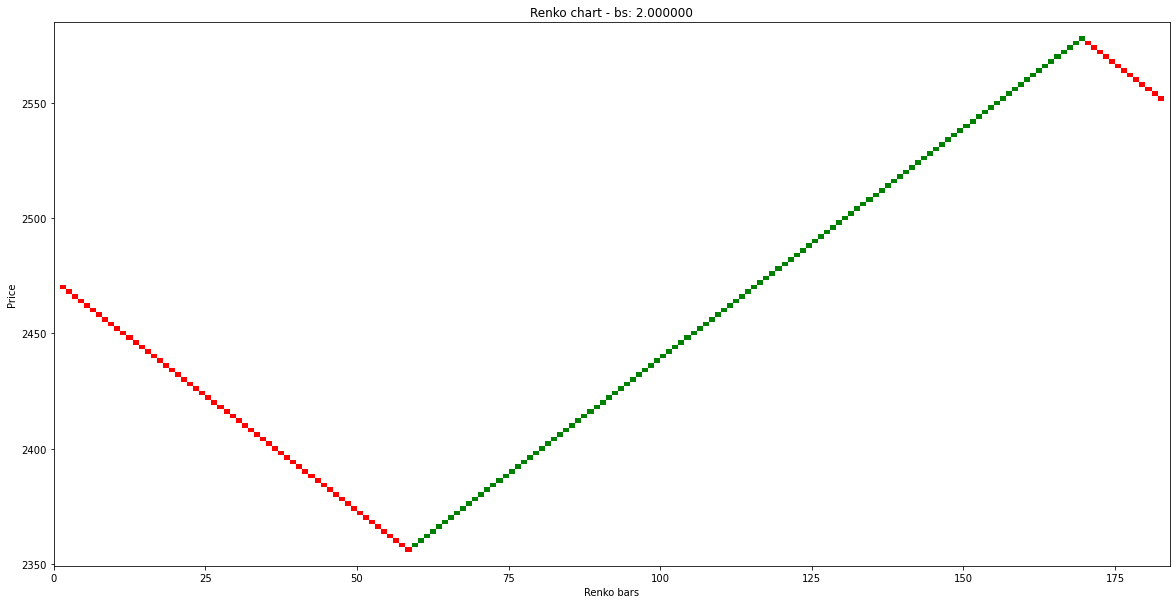

In [3]:
r = Renko()
rr = RenkoFixBrickSize(2, r)


prices = [2471.09,2354.01,2370.74,2509.33,2580.77,2549.21]
dates = ["2021-06-10","2021-06-11","2021-06-12","2021-06-13","2021-06-14","2021-06-15"]
volumes = [1000*i for i in [741.237,587.364,767.439,715.929,684.184,405.17]]
rr._initial_brick( prices[0], dates[0], volumes[0])
for i in range(1,len(prices)):
    rr._new_brick(prices[i], dates[i], volumes[i])

rr.graph()